In [1]:
import drawSvg as draw
from drawSvg.widgets import DrawingWidget
#import numpy as np
import torch


canvas_size=(600,600)
# Create drawing
d = draw.Drawing(*canvas_size, origin='center')

marker=draw.Group()
d.append(marker)
linkage = draw.Group()
d.append(linkage)
traj=draw.Group()
d.append(traj)


def redraw_linkage(nodes=[], edges=[],node_radius=6,edge_width=5):
    linkage.children.clear()    
    for id1,id2 in edges:
        linkage.draw(draw.Line(*nodes[id1].tolist(),*nodes[id2].tolist(),stroke='gray',stroke_width=edge_width))
    for x,y in nodes[1:-1]:
        linkage.draw(draw.Circle(x,y,node_radius,fill='green'))
    x,y=nodes[0]
    linkage.draw(draw.Circle(x,y,node_radius,fill='blue'))
    x,y=nodes[-1]
    linkage.draw(draw.Circle(x,y,node_radius,fill='orange'))

def redraw_trajectory(drive_node=[],end_node=[]):
    traj.children.clear()
    for p0,p1 in zip(drive_node[:-1],drive_node[1:]):
        traj.draw(draw.Line(*p0.tolist(),*p1.tolist(),stroke='blue',stroke_width=3))
    for p0,p1 in zip(end_node[:-1],end_node[1:]):
        traj.draw(draw.Line(*p0.tolist(),*p1.tolist(),stroke='orange',stroke_width=3))
        


C:\Users\cumin\.conda\envs\AF-course\lib\site-packages\drawSvg\raster.py:18: RuntimeWarning: Failed to import CairoSVG. drawSvg will be unable to output PNG or other raster image formats. See https://github.com/cduck/drawSvg#prerequisites for more details.
Original OSError: no library called "cairo-2" was found
no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': error 0x7e
cannot load library 'libcairo.2.dylib': error 0x7e
cannot load library 'libcairo-2.dll': error 0x7e
  warnings.warn(msg, RuntimeWarning)


<IPython.core.display.Javascript object>

In [2]:
def simulate_triangle(p0, p1, l02, l12):
    v01 = (p1-p0) / torch.norm(p1 - p0)
    l01 = torch.norm(p1 - p0)
    cos_v=(l01**2+l02**2-l12**2)/(2*l01*l02)
    cos_phi=torch.max(torch.min(cos_v,torch.tensor([1])),torch.tensor([-1]))
    sin_phi=torch.sqrt(1-cos_phi**2)
    rotation_matrix=torch.reshape(torch.stack((cos_phi,-sin_phi,sin_phi,cos_phi)),(2,2))
    p2=rotation_matrix@v01*l02+p0
    return p2
def simulate_linkage(nodes,edges,lengths):
    nodes_new=torch.zeros_like(nodes)
    nodes_new[0:2,:]=nodes[0:2,:]
    for i in range(0,len(edges),2):
        e02,e12 = edges[[i,i+1],:]
        l02,l12 = lengths[[i,i+1]]
        p0, p1 = nodes_new[[e02[0],e12[0]],:]
        
        if torch.norm(p1-p0) > l02 + l12:
            p0 = p1 - (l02+l12)*(p1-p0) / torch.norm(p1 - p0)
            nodes_new[e02[0],:] = p0
        
        p2 = simulate_triangle(p0,p1,l02,l12)
        nodes_new[e02[1],:] = p2
    return nodes_new

In [3]:
nodes=torch.DoubleTensor([(100,100),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0)])
edges=torch.IntTensor([(0,2),(1,2),(2,3),(1,3),(1,4),(0,4),(3,5),(4,5),(5,6),(4,6)])
lengths=torch.DoubleTensor([100,100,100,100,100,150,100,100,150,100])
drive_node=[]
end_node=[]
nodes_sim=nodes
# Create interactive widget and register mouse events
widget = DrawingWidget(d)
@widget.mousedown
def mousedown(widget, x, y, info):
    drive_node.append(torch.tensor([x,y]))
    if len(drive_node)>1:
        for i in range(0,10):
            nodes[0,:]=(1-i/10.0)*drive_node[-2]+(i/10.0)*drive_node[-1]
            nodes_sim=simulate_linkage(nodes,edges,lengths)
            end_node.append(nodes_sim[-1])
    else:
        nodes_sim=simulate_linkage(nodes,edges,lengths)
        end_node.append(nodes_sim[-1])
    print(f'drive node:{nodes_sim[0].tolist()}, end node: {nodes_sim[-1].tolist()}')
    redraw_trajectory(drive_node,end_node)
    redraw_linkage(nodes_sim,edges)
    widget.refresh()
@widget.mousemove
def mousemove(widget, x, y, info):
    nodes[0]=torch.tensor([x,y])
    nodes_sim=simulate_linkage(nodes,edges,lengths)
    redraw_trajectory(drive_node,end_node)
    redraw_linkage(nodes_sim,edges)
    widget.refresh()

widget

DrawingWidget()

In [18]:
def approx(nodes,edges,lengths):
    return torch.norm(simulate_linkage(nodes,edges,lengths)[-1]-target)**2
nodes=torch.DoubleTensor([(-60,30),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0)])
edges=torch.IntTensor([(0,2),(1,2),(2,3),(1,3),(1,4),(0,4),(3,5),(4,5),(5,6),(4,6)])
lengths=torch.tensor([100,100,100,100,100,150,100,100,150,100],dtype=torch.double,requires_grad=True)
#res=torch.norm(simulate_linkage_obj(lengths)-torch.tensor([44.7470,-194.6661]))**2
target=torch.tensor([45.,-195.])
res=approx(nodes,edges,lengths)
res.backward()
print(lengths.grad)
torch.autograd.gradcheck(approx,(nodes,edges,lengths),eps=1e-6, atol=1e-4)


tensor([ 0.4815, -0.5488,  0.3513, -0.2459, -0.0656, -1.0634,  0.3123, -0.2748,
         0.4600, -1.1257], dtype=torch.float64)


True

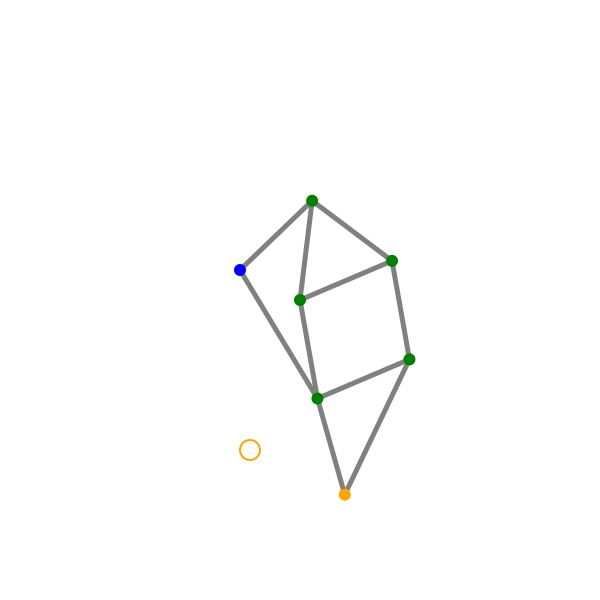

In [34]:
nodes=torch.DoubleTensor([(-60,30),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0)])
edges=torch.IntTensor([(0,2),(1,2),(2,3),(1,3),(1,4),(0,4),(3,5),(4,5),(5,6),(4,6)])
lengths=torch.DoubleTensor([100,100,100,100,100,150,100,100,150,100])
target=torch.tensor([-50.,-150.])
nodes_sim=simulate_linkage(nodes,edges,lengths)
traj.children.clear()
marker.children.clear()
marker.append(draw.Circle(*target.tolist(),r=10.,fill='white',stroke_width=2, stroke='orange'))
redraw_linkage(nodes_sim,edges)
d

0 10972.057861835925
100 195.6479489255146
200 2.903306516674934
300 0.025943188520983956
400 0.00021679020189526848
500 1.7995954642271844e-06
tensor([108.7151,  89.9070, 106.3897,  95.4718,  93.6190, 142.6576, 105.4283,
         93.1681, 159.3873,  84.8845], dtype=torch.float64, requires_grad=True)
tensor([[ -60.0000,   30.0000],
        [   0.0000,    0.0000],
        [  35.0314,   82.8014],
        [  95.3492,   -4.8372],
        [  12.6772,  -92.7568],
        [ 104.2566, -109.8886],
        [ -50.0007, -150.0006]], dtype=torch.float64, grad_fn=<CopySlices>)


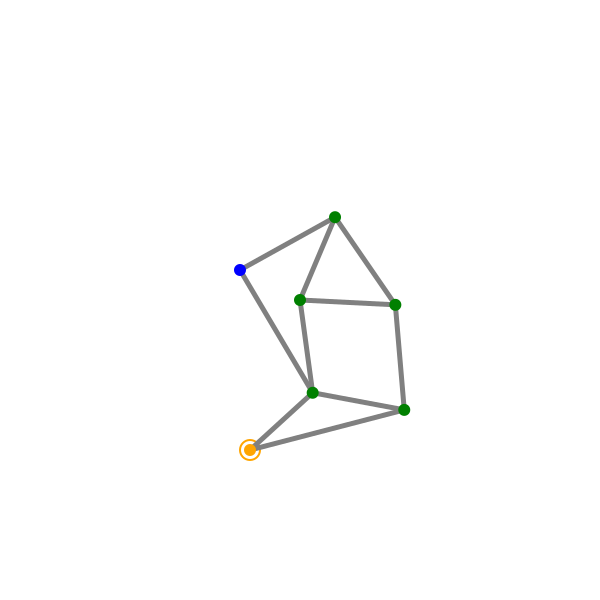

In [33]:
lengths=torch.tensor([100,100,100,100,100,150,100,100,150,100],dtype=torch.double,requires_grad=True)
step=1e-3
for t in range(2000):
    target_pred=simulate_linkage(nodes,edges,lengths)[-1]
    obj_func=torch.norm(target-target_pred)**2
    if obj_func<1e-6:
        break
    if t % 100 == 0:
        print(t, obj_func.item())
    obj_func.backward()
    with torch.no_grad():
        lengths-=step*lengths.grad
        lengths.grad=None
print(lengths)    
nodes_opt=simulate_linkage(nodes,edges,lengths)
print(nodes_opt)
redraw_linkage(nodes_opt,edges)
d

In [44]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
drive_pos=torch.DoubleTensor([[-60,30],[-100,-30]])
target_pos=torch.DoubleTensor([[-50.,-150.],[90.,-200.]])
lengths=torch.DoubleTensor([100,100,100,100,100,150,100,100,150,100])
def redraw_multistable(n=0):
    nodes[0]=drive_pos[n]
    target=target_pos[n]
    nodes_sim=simulate_linkage(nodes,edges,lengths)
    traj.children.clear()
    marker.children.clear()
    marker.append(draw.Circle(*target.tolist(),r=10.,fill='white',stroke_width=3, stroke='orange'))
    redraw_linkage(nodes_sim,edges)
    display(d)
interact(redraw_multistable,n=(0,len(drive_pos)-1))

interactive(children=(IntSlider(value=0, description='n', max=1), Output()), _dom_classes=('widget-interact',)…

<function __main__.redraw_multistable(n=0)>

In [46]:
lengths=torch.tensor([100,100,100,100,100,150,100,100,150,100],dtype=torch.double,requires_grad=True)
step=1e-3
# drive_pos=torch.tensor([[-60,30],[-60,-30]],dtype=torch.double,requires_grad=True)
for t in range(5000):
    obj_func=0
    for nodes[0],target in zip(drive_pos,target_pos):
        target_pred=simulate_linkage(nodes,edges,lengths)[-1]
        obj_func+=torch.norm(target-target_pred)**2
    if obj_func<1e-6:
        break
    if t % 100 == 0:
        print(t, obj_func.item())
    obj_func.backward()
    with torch.no_grad():
        lengths-=step*lengths.grad
#         drive_pos-=step*drive_pos.grad
        lengths.grad=None
interact(redraw_multistable,n=(0,len(drive_pos)-1))

0 18108.948907130063
100 1499.0067251972296
200 1003.0118592655489
300 620.9148651180126
400 379.1511146462733
500 245.56279989126358
600 170.19802781987588
700 122.9729075065806
800 90.60405544118298
900 67.32125581089507
1000 50.209107871206356
1100 37.51402126291428
1200 28.055065949184343
1300 20.991750017120467
1400 15.710865854397673
1500 11.759820829567246
1600 8.802554945136071
1700 6.588666875092441
1800 4.931176923672672
1900 3.6902717186876415
2000 2.7613165369311945
2100 2.0659642970995686
2200 1.5455358443731055
2300 1.1560783980940101
2400 0.8646702975672192
2500 0.646654634000543
2600 0.48356688866496816
2700 0.3615819245005593
2800 0.2703500216932275
2900 0.20212450997791925
3000 0.15110801775818047
3100 0.11296263367665958
3200 0.08444295599366106
3300 0.06312125839120865
3400 0.0471816917230333
3500 0.035266212210777706
3600 0.026359257328192356
3700 0.019701440263081356
3800 0.014724971799932604
3900 0.011005346982195031
4000 0.008225204938697425
4100 0.0061472979380

interactive(children=(IntSlider(value=0, description='n', max=1), Output()), _dom_classes=('widget-interact',)…

<function __main__.redraw_multistable(n=0)>

In [ ]:
# dynamics simulation 

def get_force(angle, mass): return mass * -9.81 * np.sin(angle)
# game loop implementation

# system parameters
pendulum_mass = 0.7  #kg
pendulum_string_length = 0.1 #m

# step
dt = 0.01

# system state (incl. initial conditions)
pendulum_angle = 1.2
pendulum_angular_velocity = 0

result = []

# step between 0s and 10s every dt seconds
for step in np.arange(0.0, 100.0, dt):
    # get acceleration
    # F = m*a  ->  a = F/m
    
    # TODO implement update call
    
    result.append(pendulum_angle)
    
plt.plot(result)
plt.show()

In [ ]:
# dynamics simulation 

def get_force(angle, mass): return mass * -9.81 * np.sin(angle)
# game loop implementation

# system parameters
pendulum_mass = 0.7  #kg
pendulum_string_length = 0.1 #m

# step
dt = 0.01

# system state (incl. initial conditions)
pendulum_angle = 1.2
pendulum_angular_velocity = 0

result = []

# step between 0s and 10s every dt seconds
for step in np.arange(0.0, 100.0, dt):
    # get acceleration
    # F = m*a  ->  a = F/m
    acceleration = get_force(pendulum_angle, pendulum_mass) / pendulum_mass
    
    # do the time step
    pendulum_angle += pendulum_angular_velocity * dt
    pendulum_angular_velocity += acceleration * dt
    result.append(pendulum_angle)
    
plt.plot(result)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# is an approximation since time is discretized

# let's be a little smarter about discretization

# battle plan formulate system as a continuous-time model -> pass it to a differential equation solver

# function that returns dy/dt
# variable naming convention from control theory:
# y -> system state vector (sometimes 'u')
# t -> time
# p -> parameter vector
def model(t, y, p=()):
    pendulum_angle = y[0]
    pendulum_anglular_velocity = y[1]
    
    # TODO implement model

# initial condition
y0 = [0,10]

from scipy.integrate import solve_ivp

# time points
time_span = (0.0, 100.0)

# solve ODEs
k = 0.1
result = solve_ivp(model, time_span, y0, method='RK45', rtol=1e-8)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 2)
ax.plot(result.y[0, :],
        result.y[1, :])
ax.set_title("solve_ivp")
result
# time plot

In [ ]:
# @Lukas TODO put it on the repo in seperate file
import matplotlib.pyplot as plt

# is an approximation since time is discretized

# let's be a little smarter about discretization

# battle plan formulate system as a continuous-time model -> pass it to a differential equation solver

# function that returns dy/dt
# variable naming convention from control theory:
# y -> system state vector (sometimes 'u')
# t -> time
# p -> parameter vector
def model(t, y, p=()):
    pendulum_angle = y[0]
    pendulum_anglular_velocity = y[1]
    
    acceleration = get_force(pendulum_angle, pendulum_mass) / pendulum_mass
    
    return [pendulum_angular_velocity, acceleration]

# initial condition
y0 = [0,10]

from scipy.integrate import solve_ivp


# time points
time_span = (0.0, 100.0)

# solve ODEs
k = 0.1
result = solve_ivp(model, time_span, y0, method='RK45', rtol=1e-8)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 2)
ax.plot(result.y[0, :],
        result.y[1, :])
ax.set_title("solve_ivp")
result
# time plot

In [ ]:
# TODO state-space-plot


In [ ]:
# TODO make this work for the linkage system


In [ ]:
# TODO run FFT on the data
